In [1]:
import osmium
import shapely.wkb as wkblib
import pandas as pd
import geopandas
import osmnx as ox
import matplotlib.pyplot as plt
import psutil

In [2]:
#uncomment and download data if you need it
!wget http://download.geofabrik.de/europe/sweden-latest.osm.pbf

--2023-03-13 18:01:35--  http://download.geofabrik.de/europe/sweden-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 65.109.48.72, 65.109.50.43
Connecting to download.geofabrik.de (download.geofabrik.de)|65.109.48.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657522876 (627M) [application/octet-stream]
Saving to: ‘sweden-latest.osm.pbf’

sweden-latest.osm.p 100%[===================>] 627.06M  92.9MB/s    in 7.1s    

2023-03-13 18:01:43 (88.7 MB/s) - ‘sweden-latest.osm.pbf’ saved [657522876/657522876]



In [3]:
#https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00

In [4]:
#this class creates
#multipolygons for all buildings. Uses "area", and I don't know
#if e.g. "way" or "relation" also could/should be used.
#Inspiration from here https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00
class BuildingHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.building_count = 0
        self.buildings = []
        # A global factory that creates WKB from a osmium geometry
        self.wkbfab = osmium.geom.WKBFactory()

    def area(self, w):
        if w.tags.get("building") == 'yes':
            try:
                wkb = self.wkbfab.create_multipolygon(w)
                geo = wkblib.loads(wkb, hex=True)
            except Exception as e:
                print(e)
                return
            row = { "w_id": w.id, "geometry": geo }

            for key, value in w.tags:
                row[key] = value

            self.buildings.append(row)
            self.building_count += 1

In [5]:
#this runs the actual loading from the file, might take a while
buildinghandler = BuildingHandler()
buildinghandler.apply_file("sweden-latest.osm.pbf", locations=True)

In [6]:
len(buildinghandler.buildings)

2022401

In [7]:
psutil.virtual_memory().percent

22.3

In [8]:
#first to a pandas dataframe and then to geopandas
df = pd.DataFrame(buildinghandler.buildings[:100000])
gdf = geopandas.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs("EPSG:4326")
gdf = ox.project_gdf(gdf)

In [49]:
#dropping all buildings that don't have level information
gdf = gdf.dropna(subset=['building:levels'])
gdf.shape

(3056, 410)

In [62]:
#taking a look at the mean levels
gdf['building:levels'].astype(float).mean()

2.919011780104712

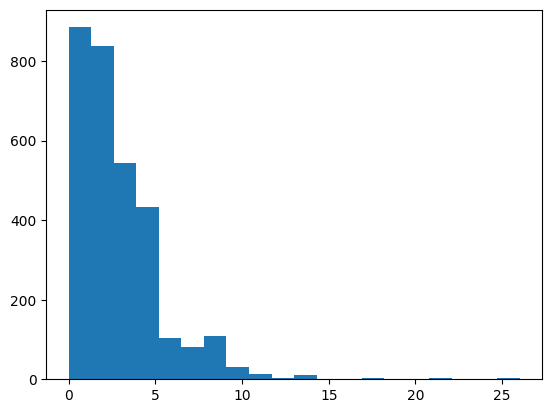

In [161]:
#taking a look at the building levels in the 100000 building sample
plt.hist(gdf['building:levels'].astype(float), bins=20)
plt.show()

In [78]:
#if one wants to store a gdf, this is how you do it
#gdf.to_file('datafram.shp')

/tmp/ipykernel_2616/2662106380.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('datafram.shp')


In [84]:
#learning new stuff about the projection
gdf.crs

<Derived Projected CRS: +proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [85]:
#testing filtering out the Stockholm region using the cx-function
#gdf_s = gdf.cx[672205:6579860, 676862:6577873]

In [9]:
i = 200000
while i < len(buildinghandler.buildings):
    dfx = pd.DataFrame(buildinghandler.buildings[(i-200000):min([i, len(buildinghandler.buildings)-1])])
    gdfx = geopandas.GeoDataFrame(dfx, geometry='geometry')
    gdfx = gdfx.set_crs("EPSG:4326")
    gdfx = ox.project_gdf(gdfx)
    gdfx = gdf.cx[672205:6579860, 676862:6577873]
    #gdfx = gdfx.dropna(subset=['building:levels'])
    gdfx = gdfx[['w_id', 'geometry', 'building:levels']]
    if i < 200001:
        meta = gdfx
    else:
        meta = pd.concat([meta, gdfx])
    print(meta.shape)
    i += 200000

(943, 3)
(1886, 3)
(2829, 3)
(3772, 3)
(4715, 3)
(5658, 3)
(6601, 3)
(7544, 3)
(8487, 3)
(9430, 3)


In [14]:
metal = meta.dropna(subset=['building:levels'])
metal.shape

(810, 3)

In [ ]:
metal['floorarea'] = metal.area * metal['building:levels'].astype(float)
#metal = metal[meta['building:levels'].str.contains('[A-Za-z]') == False]

In [17]:
metal['floorarea']

107      11743.984416
114       2031.588532
783       4490.550194
805        672.347392
941      14555.442774
             ...     
61137      504.972199
62040      285.919652
62043      184.621453
62046      112.947263
73236      206.724128
Name: floorarea, Length: 810, dtype: float64

In [ ]:
#multiplying floor area with figure from Antti's model, using climate zone 5 for Stockholm
metal['kWh/a'] = metal['floorarea'] * 159.993

In [19]:
#using this article https://www.sei.org/publications/swedish-heat-energy-system-new-tensions-and-lock-ins-after-a-successful-transition/#:~:text=Fossil%20fuel%20energy%20has%20been,demand%20for%20heating%20in%20buildings.
#to calculate an estimate of the energy mix and it's co2-emissions using Antti's model
co2 = 0.5*0.195 + 0.25*0.104 + 0.08*0.255 + 0.08*0.354 + 0.09*0.403
co2

0.20848999999999998

In [ ]:
#multiplying kWh with co2/kWh for estimate of co2-emissions
metal['yearly-co2'] = metal['kWh/a'] * co2

In [25]:
metal = metal.rename(columns={'building:levels':'levels', 'yearly-co2':'co2/a'})

In [26]:
metal.head()

,w_id,geometry,levels,floorarea,kWh/a,co2/a
107,29741604,"MULTIPOLYGON (((675282.055 6577525.008, 675296...",4,11743.984416,1.878955e+06,391743.390228
114,29752940,"MULTIPOLYGON (((672911.430 6576548.124, 672930...",4,2031.588532,3.250399e+05,67767.577923
783,47971704,"MULTIPOLYGON (((678820.355 6571576.675, 678825...",2,4490.550194,7.184566e+05,149791.015938
805,48029436,"MULTIPOLYGON (((679299.694 6574068.135, 679318...",2,672.347392,1.075709e+05,22427.451988
941,48780448,"MULTIPOLYGON (((673941.779 6572849.976, 673941...",1,14555.442774,2.328769e+06,485525.039569


In [27]:
metal.to_file('sodermalm.shp')

In [29]:
how_to_read = geopandas.read_file('sodermalm.shp')
how_to_read.head()

,w_id,levels,floorarea,kWh/a,co2/a,geometry
0,29741604,4,11743.984416,1.878955e+06,391743.390228,"POLYGON ((675282.055 6577525.008, 675301.606 6..."
1,29752940,4,2031.588532,3.250399e+05,67767.577923,"POLYGON ((672911.430 6576548.124, 672922.732 6..."
2,47971704,2,4490.550194,7.184566e+05,149791.015938,"POLYGON ((678820.355 6571576.675, 678839.388 6..."
3,48029436,2,672.347392,1.075709e+05,22427.451988,"POLYGON ((679299.694 6574068.135, 679308.462 6..."
4,48780448,1,14555.442774,2.328769e+06,485525.039569,"POLYGON ((673941.779 6572849.976, 674217.168 6..."
